# 이미지로 성별, 나이 예측 CNN 모델 만들기



## 데이터 불러오기

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seozinidev","key":"875d6e33c22c56ceefe12aacba2bd0ce"}'}

In [ ]:
ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#colab으로 utkface data 불러오기
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
100% 331M/331M [00:01<00:00, 236MB/s]
100% 331M/331M [00:01<00:00, 185MB/s]


In [ ]:
# 다운받은 폴더 압축 풀기
!unzip utkface-new.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327523.jpg.chip.jp

In [ ]:
#https://www.kaggle.com/mohamedahmedae/utkface-v2-gender-97-race-94-age-mae-0-05 코드 참고
# 필요한 라이브러리 IMPORT
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import seaborn as sns
import plotly.graph_objects as go


# 숫자로 표현되어있는 인종, 성별 데이터를 문자열로 변환해주기 위한 dictionary 생성
dataset_dict = {
    'race_id': {
        0: 'white',
        1: 'black',
        2: 'asian',
        3: 'indian',
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

folder_name = 'UTKFace'

# 데이터 프레임으로 만들어주기 위한 함수 지정

def parse_dataset(dataset_path, ext='jpg'):

    def parse_info_from_file(path):
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None

    files = glob(os.path.join(dataset_path, "*.%s" % ext))

    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)

    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()

    return df

df = parse_dataset(folder_name)

df.head()

age  gender    race                                           file
0  78.0  female   white  UTKFace/78_1_0_20170120140110282.jpg.chip.jpg
1  25.0  female  indian  UTKFace/25_1_3_20170104232101034.jpg.chip.jpg
2  44.0  female  indian  UTKFace/44_1_3_20170119165329470.jpg.chip.jpg
3   2.0  female  others   UTKFace/2_1_4_20161221202428169.jpg.chip.jpg
4  50.0    male   asian  UTKFace/50_0_2_20170119205049471.jpg.chip.jpg

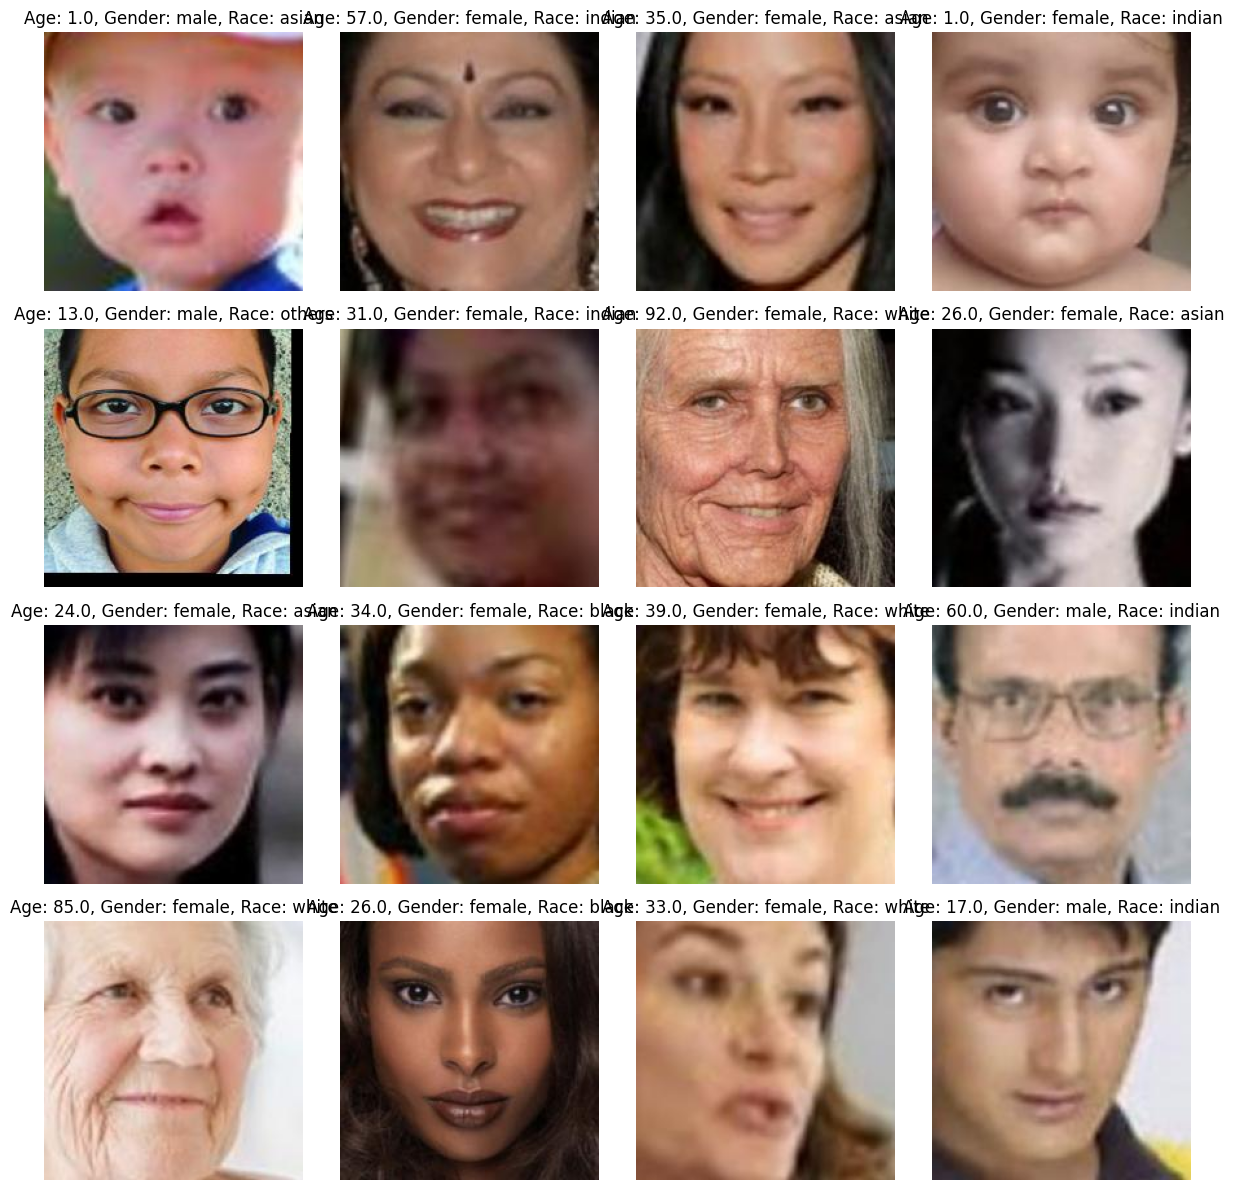

In [ ]:
import random

# 전체 이미지에서 랜덤으로 16개 선택
random_images = df.sample(n=16, random_state=42)  # random_state를 설정하면 매번 같은 결과를 얻을 수 있습니다.

# 이미지 출력
plt.figure(figsize=(12, 12))
for i, row in enumerate(random_images.itertuples()):
    img = cv2.imread(row.file)  # 이미지 파일 읽기
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR에서 RGB로 변환
    plt.subplot(4, 4, i + 1)  # 4x4 서브플롯 생성
    plt.imshow(img)
    plt.axis('off')  # 축 제거
    plt.title(f"Age: {row.age}, Gender: {row.gender}, Race: {row.race}")  # 제목에 나이, 성별, 인종 표시
plt.tight_layout()  # 레이아웃 조정
plt.show()


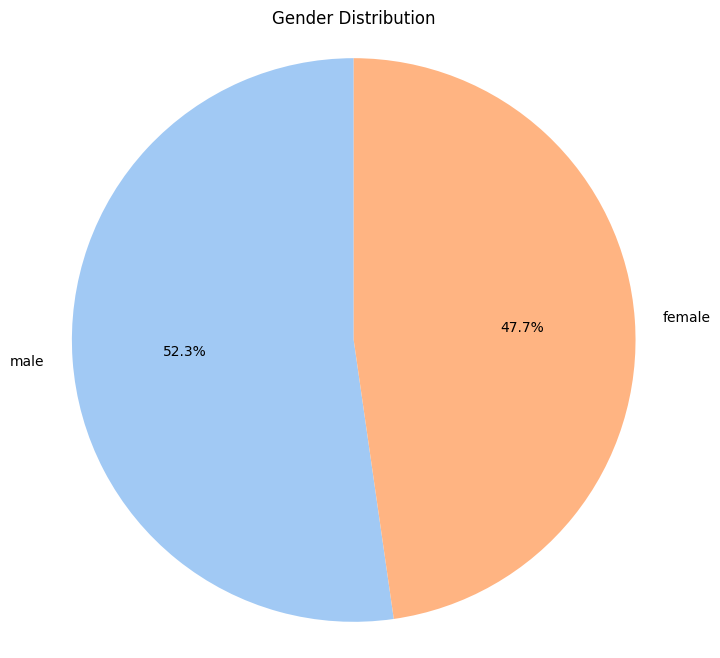

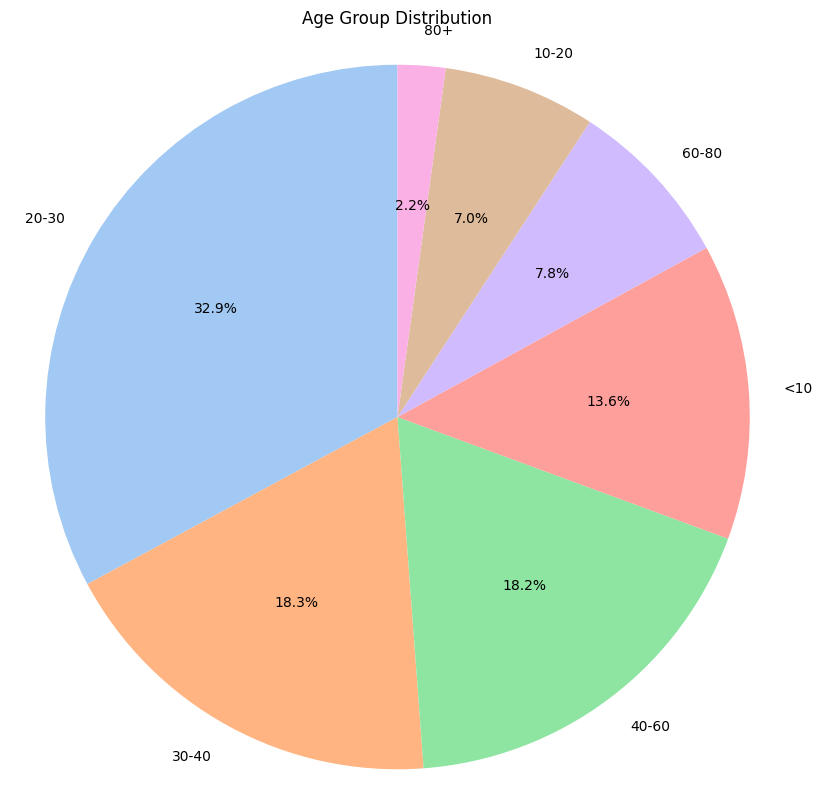

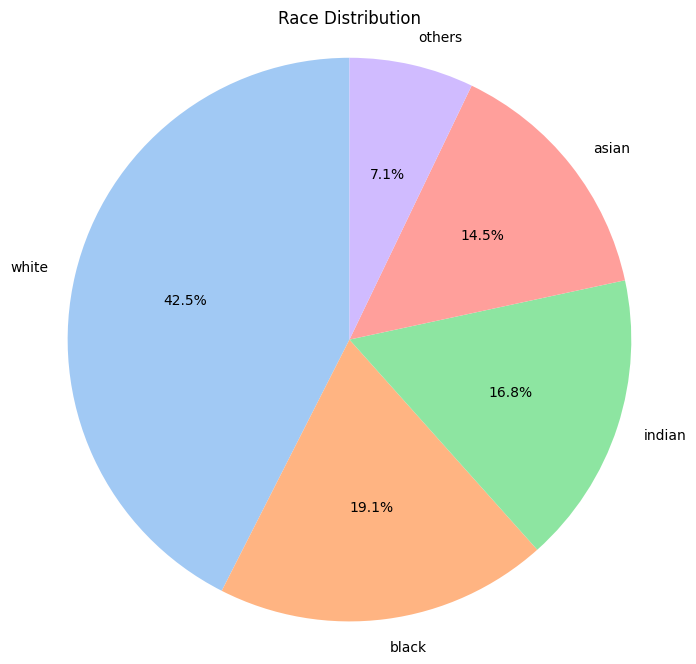

In [ ]:
# 성별 비율
gender_counts = df['gender'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Gender Distribution')
plt.axis('equal')  # 원형을 유지
plt.show()

# 연령 비율
# 나이 범주 정의
bins = [-1, 10, 20, 30, 40, 60, 80, 100]  # 나이 구간 (최소값에서 최대값)
labels = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']  # 범주 레이블

# 나이를 범주로 변환
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

# 나이 그룹 비율 계산
age_group_counts = df['age_group'].value_counts(normalize=True) * 100

# 원형 차트 시각화
plt.figure(figsize=(10, 10))
plt.pie(age_group_counts, labels=age_group_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Age Group Distribution')
plt.axis('equal')  # 원형 유지
plt.show()


# 인종 비율
race_counts = df['race'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 8))
plt.pie(race_counts, labels=race_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Race Distribution')
plt.axis('equal')  # 원형을 유지
plt.show()


## CNN 모델 만들기

In [ ]:
#MODEL 구축을 위한 라이브러리 import
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPool2D, Activation, Dropout, Lambda, Dense, Flatten, Input
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as k

In [ ]:
images = []
age = []
gender = []
for img in os.listdir(folder_name):
  ages = img.split("_")[0]
  genders = img.split("_")[1]
  img = cv2.imread(str(folder_name)+"/"+str(img))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = img
  images.append(np.array(img))
  age.append(np.array(ages))
  gender.append(np.array(genders))

age = np.array(age,dtype=np.int64)
images = np.array(images)
gender = np.array(gender,np.uint64)

모델 학습과 검증을 위해 age, images, gender에 각각 저장된 데이터를

 Train Set : Validaton Set : Test Set = 6 : 2 : 2의 비율로 나눔.  
나이 예측을 위한 모델과 성별 예측을 위한 모델을 따로 만들기 위해 각각의 데이터 셋으로 만들어줌.




In [ ]:
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(images, age, random_state=42, test_size=0.4)
x_valid_age, x_test_age, y_valid_age, y_test_age = train_test_split(x_test_age, y_test_age, random_state=42, test_size = 0.5)

x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(images, gender, random_state=42, test_size=0.4)
x_valid_gender, x_test_gender, y_valid_gender, y_test_gender = train_test_split(x_test_gender, y_test_gender, random_state=42, test_size=0.5)

나이 학습을 위한 age_model과 성별 학습을 위한 gender_model 두 모델을 만들어주고 학습


Callback 함수로  ModelCheckpoint와 EarlyStopping를 사용



ModelCheckpoint는 체크포인트를 저장할 때 쓰이고,

EarlyStopping은 validation loss가 더 이상 개선이 없을 때 과적합을 방지하기 위해 훈련을 중단하는 용도로 쓰임

In [ ]:
#learning rate 설정
init_lr = 1e-4
epochs = 50


# age_model 학습을 위한 optimizer 생성
opt_age = Adam(learning_rate=init_lr)

# 과적합 방지를 위한 callback 설정
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5),
             ModelCheckpoint(filepath='./model-{epoch:02d}-{val_loss:.2f}.keras',
                             monitor='val_loss',
                             save_best_only=True)]


# age_model
age_model = Sequential([
    Conv2D(128, kernel_size =3, input_shape=(200,200,3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(128, kernel_size =3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(256, kernel_size =3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(512, kernel_size =3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Flatten(),
    Dropout(0.25),
    Dense(512, activation  = 'relu'),
    Dense(1, activation = 'linear', name = 'age')
])
# age_model 컴파일
age_model.compile(loss="mse", optimizer=opt_age, metrics=['mae'])


#gender model

# gender_model 학습을 위한 optimizer 생성
opt_gender = Adam(learning_rate=init_lr)

gender_model = Sequential([
    Conv2D(36, kernel_size=3,input_shape=(200,200,3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(64, kernel_size=3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(128, kernel_size=3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(256, kernel_size=3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(512, kernel_size=3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Flatten(),
    Dropout(0.25),
    Dense(512, activation  = 'relu'),
    Dense(1, activation = 'sigmoid', name = 'gender')
])

# gender_model 컴파일
gender_model.compile(optimizer=opt_gender, loss='binary_crossentropy', metrics=['accuracy'])

#age_model 학습
history_age = age_model.fit(x_train_age, y_train_age,
                        validation_data=(x_valid_age, y_valid_age), batch_size = 32, epochs=50, callbacks = callbacks)
#gender_model 학습
history_gender = gender_model.fit(x_train_gender, y_train_gender,
                        validation_data=(x_valid_gender, y_valid_gender), batch_size=32, epochs=50, callbacks = callbacks)

Epoch 1/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 261.1900 - mae: 12.1152 - val_loss: 195.3825 - val_mae: 10.0770
Epoch 2/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 127.4908 - mae: 8.4701 - val_loss: 127.4090 - val_mae: 8.0512
Epoch 3/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 104.4689 - mae: 7.5666 - val_loss: 101.4331 - val_mae: 7.4507
Epoch 4/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 84.5198 - mae: 6.7728 - val_loss: 103.1043 - val_mae: 7.2820
Epoch 5/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 73.2405 - mae: 6.3731 - val_loss: 96.5761 - val_mae: 7.2746
Epoch 6/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 65.8002 - mae: 6.0462 - val_loss: 112.4050 - val_mae: 7.4821
Epoch 7/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 57.1376 - mae: 5.6036 - val_loss: 123.8963 - val_mae: 8.3556
Epoch 8/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 55.1317 - mae: 5.5250 - val_loss: 87.9419 - val_mae: 7.0120
Epoch 9/50
44

In [ ]:
age_model.save('/content/drive/MyDrive/Colab Notebooks/seojin/hackerton/model/age_model.keras')
gender_model.save('/content/drive/MyDrive/Colab Notebooks/seojin/hackerton/model/gender_model.keras')


In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/Colab Notebooks/seojin/hackerton/model/age_model.keras')
files.download('/content/drive/MyDrive/Colab Notebooks/seojin/hackerton/model/gender_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf

# TensorFlow 버전 확인
print("TensorFlow version:", tf.__version__)

# Keras 버전 확인 (TensorFlow 2.x에서는 tf.keras를 통해 사용)
print("Keras version:", tf.keras.__version__)


TensorFlow version: 2.17.0
Keras version: 3.4.1


In [ ]:
history_age

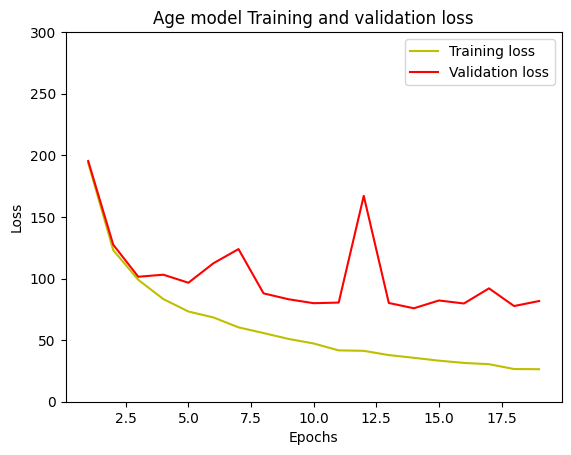

In [ ]:
history = history_age
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Age model Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,300)
plt.legend()
plt.show()
#Age model의 경우 12 epoch 이후로 val loss가 줄어들지 않아 17 epoch에서 학습을 중단

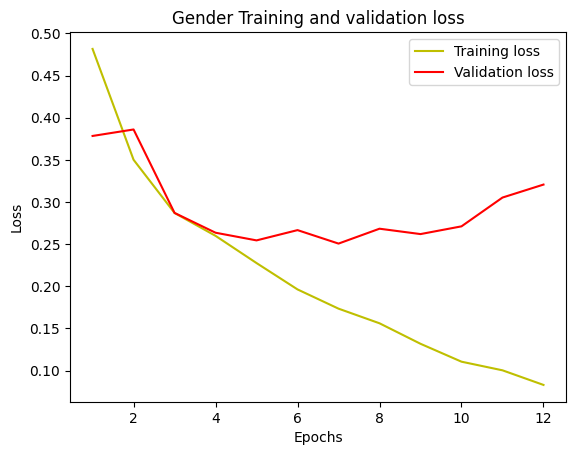

In [ ]:
history = history_gender
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Gender Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Gender model의 경우 7 epoch 이후로 val loss가 줄어들지 않아 12 epoch에서 학습을 중단


In [ ]:
len(x_test_age)

4742

In [ ]:
y_test_age[0]

37

In [ ]:
age_preds = age_model.predict(x_test_age)

149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [ ]:
gender_preds = gender_model.predict(x_test_gender)

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error, accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

In [ ]:
age_mae = mean_absolute_error(y_test_age, age_preds)

age_mae

6.549778211938837

In [ ]:
gender_accuracy = accuracy_score(y_test_gender, np.round(gender_preds))

gender_accuracy

0.8760016870518769

(array([1893.,  142.,  103.,   77.,   79.,   86.,   78.,  105.,  142.,
        2037.]),
 array([1.17285674e-16, 9.99999866e-02, 1.99999973e-01, 2.99999952e-01,
        3.99999946e-01, 4.99999940e-01, 5.99999905e-01, 6.99999928e-01,
        7.99999893e-01, 8.99999917e-01, 9.99999881e-01]),
 <BarContainer object of 10 artists>)

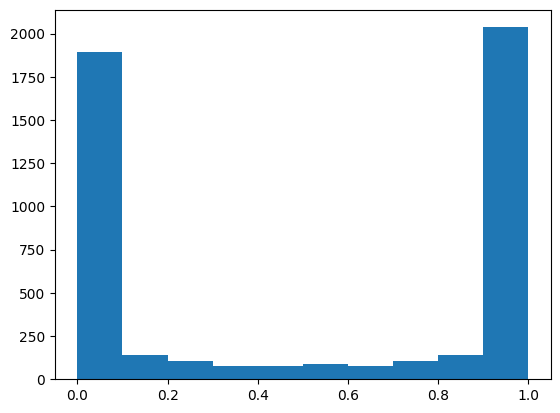

In [ ]:
plt.hist(gender_preds.ravel())

In [ ]:
print(classification_report(y_test_gender,np.round(gender_preds)))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88      2518
           1       0.83      0.92      0.87      2224

    accuracy                           0.88      4742
   macro avg       0.88      0.88      0.88      4742
weighted avg       0.88      0.88      0.88      4742



In [ ]:
confusion_matrix(y_test_gender,np.round(gender_preds))

array([[2112,  406],
       [ 182, 2042]])

<ipython-input-46-64da936804fc>:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_xlabel('predict_age: {}, predict_gender: {}'.format(int(predict_age),predict_gender))


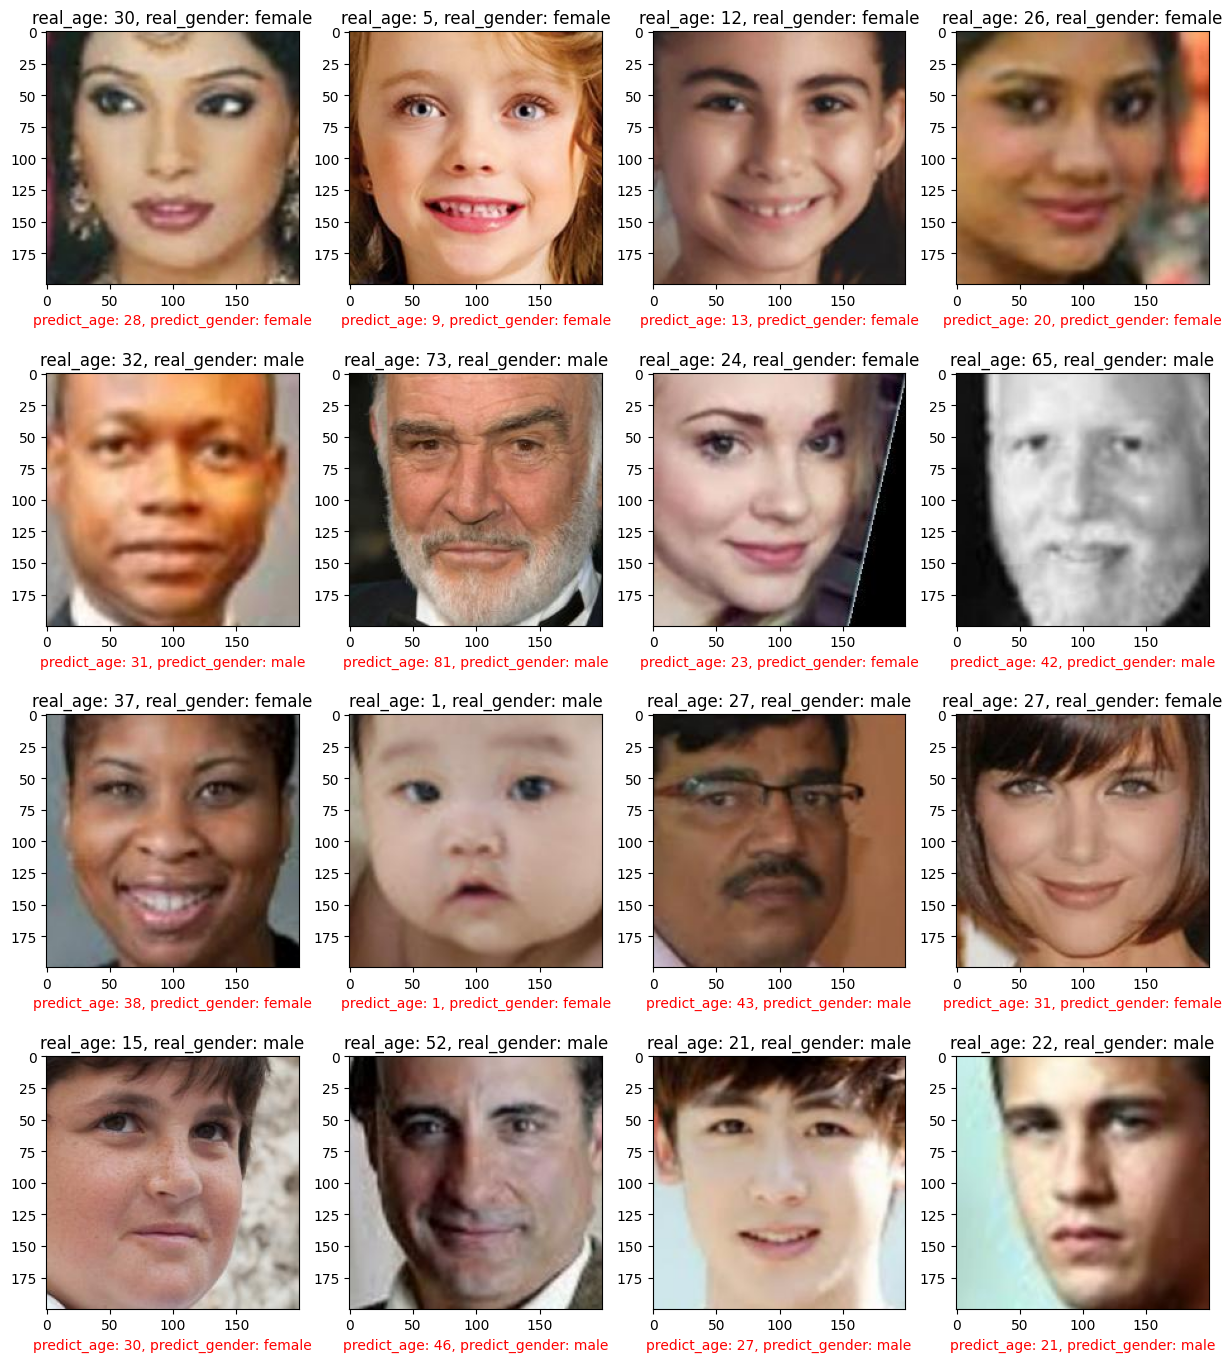

In [ ]:
import math
n=16
random_indices = np.random.choice(len(x_test_age), size=n)
n_cols = 4
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 17))
for i, x in enumerate(random_indices):
   ax = axes.flat[i]
   ax.imshow(x_test_age[x])
   real_age = y_test_age[x]
   predict_age = age_preds[x]
   if y_test_gender[x] == 1:
     real_gender = 'female'
   else:
     real_gender = 'male'
   if np.round(gender_preds[x]) == 1:
     predict_gender = 'female'
   else:
     predict_gender ='male'
   ax.set_title('real_age: {}, real_gender: {}'.format(int(real_age),real_gender))
   ax.set_xlabel('predict_age: {}, predict_gender: {}'.format(int(predict_age),predict_gender))
   ax.xaxis.label.set_color('red')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 26 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


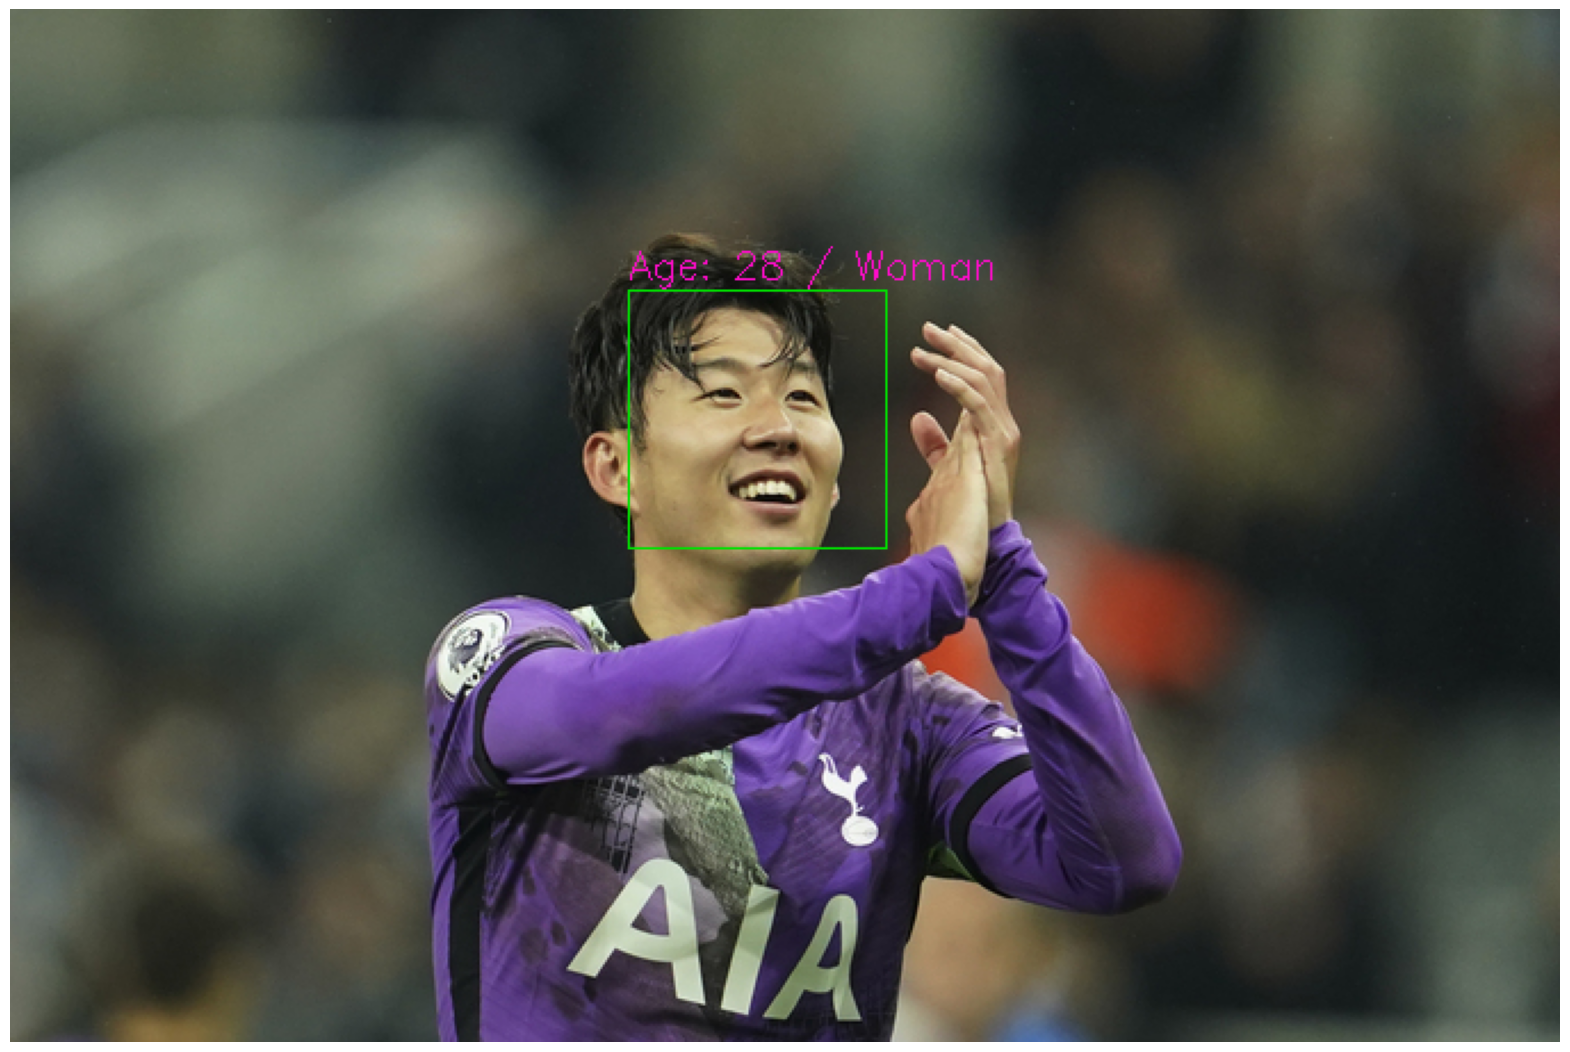

Predicted Age: 28, Predicted Gender: Woman


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 모델 로드
age_model_path = "/content/drive/MyDrive/Colab Notebooks/seojin/hackerton/model/age_model.keras"
gender_model_path = '/content/drive/MyDrive/Colab Notebooks/seojin/hackerton/model/gender_model.keras'

age_model = load_model(age_model_path)
gender_model = load_model(gender_model_path)

# 얼굴 검출을 위한 OPENCV Cascade Classifier 로드
face_cascade = cv2.CascadeClassifier("/content/drive/MyDrive/Colab Notebooks/seojin/hackerton/model/haarcascade_frontalface_default.xml")

age_ = []
gender_ = []

image_size = 200

# 이미지 로드
pic = cv2.imread('/content/drive/MyDrive/Colab Notebooks/seojin/hackerton/model/image2.jpg')
faces = face_cascade.detectMultiScale(pic, scaleFactor=1.11, minNeighbors=8)

for (x, y, w, h) in faces:
    img = pic[y:y + h, x:x + w]
    img = cv2.resize(img, (image_size, image_size))

    # 모델 예측
    age_predict = age_model.predict(np.array(img).reshape(-1, image_size, image_size, 3))
    gender_predict = gender_model.predict(np.array(img).reshape(-1, image_size, image_size, 3))

    # 예측 결과 처리
    age_ = int(age_predict[0][0])  # 예측 결과가 2D 배열일 경우 첫 번째 요소 가져오기
    gender_ = np.round(gender_predict[0][0])  # 첫 번째 요소를 반올림

    if gender_ == 0:
        gender_label = 'Man'
        col = (255, 255, 0)
    else:
        gender_label = 'Woman'
        col = (203, 12, 255)

    # 이미지에 결과 표시
    cv2.rectangle(pic, (x, y), (x + w, y + h), (0, 225, 0), 1)
    cv2.putText(pic, f"Age: {age_} / {gender_label}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, w * 0.005, col, 1)

# 이미지를 RGB로 변환하여 표시
pic1 = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 16))
plt.imshow(pic1)
plt.axis('off')  # 축 숨기기
plt.show()

# 최종 예측 결과 출력
print(f"Predicted Age: {age_}, Predicted Gender: {'Man' if gender_ == 0 else 'Woman'}")


## 캠으로 성별 나이 예측하기 - jupyter notebook에서 돌리기

In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import load_model

In [ ]:
# Haarcascade 파일 경로 설정
face_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
# face_cascade_path = cv2.CascadeClassifier("./model/haarcascade_frontalface_default.xml")

# Haarcascade 파일 로드
face_cascade = cv2.CascadeClassifier(face_cascade_path)
if face_cascade.empty():
    raise IOError('Haarcascade 파일을 로드할 수 없습니다.')

# 웹캠 초기화
camera = cv2.VideoCapture(0)

# 이미지 크기 설정
image_size = 224

# 모델 로드
# age_model = load_model("C:/Users/KimDongyoung/Desktop/이미지/age_model.keras")
# gender_model = load_model("C:/Users/KimDongyoung/Desktop/이미지/gender_model.keras")
age_model = load_model('./model/age_model.keras')
gender_model = load_model('./model/gender_model.keras')

# 결과를 저장할 리스트 초기화
results = []

# 이미지 저장 폴더 생성
if not os.path.exists('images'):
    os.makedirs('images')

while True:
    ret, frame = camera.read()
    if not ret:  # 웹캠에서 프레임을 읽지 못한 경우
        print("웹캠에서 프레임을 읽을 수 없습니다.")
        break

    # 얼굴 탐지
    faces = face_cascade.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=8)

    for (x, y, w, h) in faces:
        img = frame[y:y + h, x:x + w]
        img = cv2.resize(img, (image_size, image_size))
        img = np.array(img).reshape(-1, image_size, image_size, 3) / 255.0  # 입력 데이터 크기 조정 및 정규화
        img = img.astype('float32')  # 데이터 타입을 float32로 변환

        # 모델의 입력 크기 확인
        model_input_shape = age_model.input_shape[1:]  # (224, 224, 3)과 같은 형태

        # 입력 데이터 크기 조정
        if img.shape[1:] != model_input_shape:
            img = cv2.resize(img[0], (model_input_shape[0], model_input_shape[1]))  # img[0]을 사용하여 크기 조정
            img = np.array(img).reshape(-1, model_input_shape[0], model_input_shape[1], model_input_shape[2]) / 255.0
            img = img.astype('float32')

        age_predict = age_model.predict(img)
        gender_predict = gender_model.predict(img)
        age_ = int(np.round(age_predict[0][0]))
        gender_ = 'Man' if np.round(gender_predict[0][0]) == 0 else 'Woman'

        # 결과를 리스트에 저장
        results.append({
            'image_name': f'image_{len(results) + 1}.jpg',
            'age': age_,
            'gender': gender_
        })

        # 얼굴 부분만 저장
        face_img = frame[y:y + h, x:x + w]
        cv2.imwrite(os.path.join('images', f'image_{len(results)}.jpg'), face_img)

        # 결과 표시
        col = (255, 255, 0) if gender_ == 'Man' else (203, 12, 255)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 225, 0), 1)
        cv2.putText(frame, f"Age: {age_} / {gender_}",
                    (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, w * 0.005, col, 1)

    cv2.imshow("camera", frame)

    key = cv2.waitKey(10)
    # 자판의 ESC키가 27, ESC 입력시 비디오창 종료
    if key == 27:
        cv2.destroyAllWindows()
        break

# 자원 해제
camera.release()          # 웹캠 자원 해제
cv2.destroyAllWindows()   # 모든 OpenCV 창 닫기

# 결과를 CSV 파일로 저장
df_results = pd.DataFrame(results)
df_results.to_csv('results.csv', index=False)

In [ ]:
def delete_all_but_first_image(folder_path):
    """
    'images' 폴더에 저장된 모든 파일 중 맨 처음에 찍힌 사진을 제외한 나머지 파일을 삭제합니다.
    """
    # 폴더 내 모든 파일 목록을 가져옵니다.
    files = sorted(os.listdir(folder_path))

    # 맨 처음에 찍힌 사진을 제외한 나머지 파일을 삭제합니다.
    if len(files) > 1:
        for file in files[1:]:
            file_path = os.path.join(folder_path, file)
            os.remove(file_path)
            print(f"Deleted: {file_path}")
    else:
        print("폴더에 파일이 하나만 있거나 비어 있습니다.")

# 사용 예시
delete_all_but_first_image('images')

In [ ]:
def keep_first_csv_and_delete_others(csv_path):
    """
    CSV 파일 중 맨 처음에 저장된 파일을 제외한 나머지 파일을 삭제합니다.
    """
    # 폴더 내 모든 CSV 파일 목록을 가져옵니다.
    files = sorted([f for f in os.listdir(csv_path) if f.endswith('.csv')])

    # 맨 처음에 저장된 CSV 파일을 제외한 나머지 파일을 삭제합니다.
    if len(files) > 1:
        for file in files[1:]:
            file_path = os.path.join(csv_path, file)
            os.remove(file_path)
            print(f"Deleted: {file_path}")
    else:
        print("폴더에 CSV 파일이 하나만 있거나 비어 있습니다.")

keep_first_csv_and_delete_others('.')